# Plots for the 2MDM analysis

In [9]:
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from auxPlots import columnsDict, colorDict, defaultPars

pd.option_context('display.max_columns', 5)
pd.option_context('display.max_rows', 3)

pd.options.mode.chained_assignment = None #Disable copy warnings
plt.rcParams.update(defaultPars) #Figure resolution

#### Get data in pcl format and print all columns names

In [36]:
#Merge with SModelS DataFrame
pclFile = '../data/smodels_results.pcl'
dataDF = pd.read_pickle(pclFile)
dataDF.rename(columns=columnsDict,inplace=True)
dropCols = [c for c in dataDF.columns if ('Output' in c or 'weight' in c)]
dataDF.drop(columns=dropCols,inplace=True)
print(dataDF.columns.values.tolist()) #Print all columns names

['maxcond', 'theory prediction (fb)', 'upper limit (fb)', 'expected upper limit (fb)', 'TxNames', 'Mass (GeV)', 'AnalysisID', 'DataSetID', 'AnalysisSqrts (TeV)', 'lumi (fb-1)', 'dataType', 'r', 'r_expected', 'Width (GeV)', 'nll', 'nll_min', 'nll_SM', 'Total xsec for missing topologies (fb)', 'Total xsec for missing topologies with displaced decays (fb)', 'Total xsec for missing topologies with prompt decays (fb)', 'Total xsec for topologies outside the grid (fb)', 'mChi', 'mS', 'mZp', 'mass.9000002', 'mass.9000003', 'mass.9000004', 'mass.9000005', 'width.9000002', 'width.9000003', 'width.9000004', 'width.9000005', 'width.9000006', 'width.9900026', 'width.9900032', 'gchi', 'gq', 'sina', 'extpar.4', 'xsec8TeV(fb).9900032', 'xsec8TeV(fb).9900026', 'xsec13TeV(fb).9900032', 'xsec13TeV(fb).9900026', 'BRs.sd.W-,W+', 'BRs.sd.higgs,higgs', 'BRs.sd.Z,Z', 'BRs.sd.chi,chi', 'BRs.sd.ta+,ta-', 'BRs.zp.chi,chi', 'BRs.zp.c,c', 'BRs.zp.q,q', 'BRs.zp.b,b', 'BRs.zp.t-,t+', 'BRs.sd.t-,t+', 'totalxsec13TeV

#### Filter couplings

In [37]:
gchi = np.sqrt(2)
gq = 0.25
sina = 0.25
dataDF = dataDF[((np.abs(dataDF['gchi']-gchi) < 0.001) 
                 & (dataDF['gq'] == gq) & (dataDF['sina'] == sina))]

#### Set r = 0 for points with no results 

In [38]:
#Set points without results with r == 0
dataDF.fillna(value={'r' : 0}, inplace=True)
dataDF.sort_values(by='r',ascending=False,inplace=True)

#### Select points where diquark searches are the most constraining

In [39]:
metAna = ['ATLAS-SUSY-2018-22-multibin,CMS-EXO-20-004'] # Consider only the combination

diquarkAna = ['ATLAS-EXOT-2019-03', 'ATLAS-EXOT-2013-11', 'CMS-EXO-19-012', 
           'ATLAS-EXOT-2018-48', 'CMS-EXO-12-059', 'CMS-EXO-20-008', 
           'CMS-EXO-16-057']
# Remove exclusion from all analyses not listed in metAna or diquarkAna
dataDF.loc[~(dataDF['AnalysisID'].isin(metAna+diquarkAna)),'r'] = -1

# Plot Results

3000 points plotted


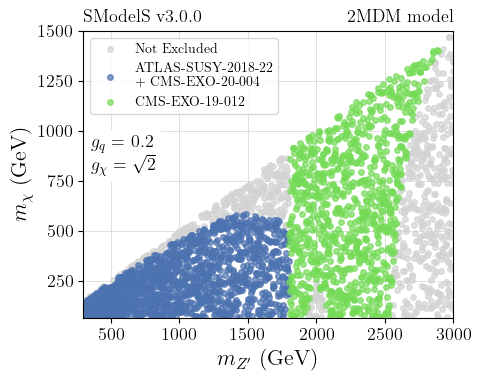

In [41]:
# Keep only the largest r for each filename:
dataDFmax = dataDF.sort_values(by='r',ascending=False).groupby(level='filename').head(1)
allowed = dataDFmax[dataDFmax['r'] < 1.0]
x = allowed['mZp']
y = allowed['mChi']
scAll = plt.scatter(x,y,color='lightgray', label='Not Excluded', alpha=0.7)
ntot = len(x)

# Finally group by analysis ID
rmax_groups = dataDFmax.groupby(by='AnalysisID')

# Sort analyses by length of name and then length of points
for ana,anadf in sorted(rmax_groups, key = lambda x: (len(x[0]),len(x[1])),reverse=True):
    excludedAna = anadf[anadf['r'] > 1.0]
    if len(excludedAna) == 0:
        continue
    x = excludedAna['mZp']
    y = excludedAna['mChi']
    if ana in ['CombinedAna','ATLAS-SUSY-2018-22-multibin,CMS-EXO-20-004']:
        label = 'ATLAS-SUSY-2018-22'+'\n'+'+ CMS-EXO-20-004'
    else:
        label = ana
    sc = plt.scatter(x,y, color=colorDict[ana], label=label, alpha=0.7)
    ntot += len(x)

print(f'{ntot} points plotted')
plt.title(r'SModelS v3.0.0', loc='left')
plt.title(r'2MDM model', loc='right')


plt.xlabel(r'$m_{Z^{\prime}}$ (GeV)')
plt.ylabel(r'$m_{\chi}$ (GeV)')
textstr = '\n'.join((
    r'$g_q =$ %1.1f' %gq, 
    r'$g_{\chi} = \sqrt{2}$'))

plt.text(0.02,0.51,textstr,
         bbox=dict(facecolor='white', edgecolor='none',alpha=1.0),transform = plt.gca().transAxes)

plt.xlim(300, 3000)
plt.ylim(65, 1500)

plt.legend()
plt.tight_layout()
plt.savefig('./figures/monojet-dijet-default-couplings_v1.png')
plt.show()